# Coursework 2 for Cardiac MR Image Segmentation (2020-2021)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

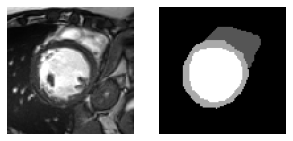

True

In [2]:
import os
import cv2 #import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [17]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNNSEG(nn.Module): # Define your model
    def __init__(self):
        super(CNNSEG, self).__init__()
        # fill in the constructor for your model here
        bn_momentum = 0.85
        
        # layer 1
        self.conv11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum=bn_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum=bn_momentum)

        # layer 2
        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum=bn_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum=bn_momentum)

        # layer 3
        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum=bn_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum=bn_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum=bn_momentum)

        # layer 4
        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum=bn_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum=bn_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum=bn_momentum)

        # layer 5
        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum=bn_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum=bn_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum=bn_momentum)

        # layer 6
        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum=bn_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum=bn_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum=bn_momentum)

        # layer 7
        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum=bn_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum=bn_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum=bn_momentum)

        # layer 8
        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= bn_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum=bn_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum=bn_momentum)

        # layer 9
        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum=bn_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum=bn_momentum)

        # layer 10
        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum=bn_momentum)
        self.conv11d = nn.Conv2d(64, 4, kernel_size=3, padding=1)


    def forward(self, x):
        # convolution
        a = F.relu6(self.bn11(self.conv11(x)))
        a = F.relu6(self.bn12(self.conv12(a)))
        a, id1 = F.max_pool2d(a,kernel_size=2, stride=2,return_indices=True)

        a = F.relu6(self.bn21(self.conv21(a)))
        a = F.relu6(self.bn22(self.conv22(a)))
        a, id2 = F.max_pool2d(a,kernel_size=2, stride=2,return_indices=True)

        a = F.relu6(self.bn31(self.conv31(a)))
        a = F.relu6(self.bn32(self.conv32(a)))
        a = F.relu6(self.bn33(self.conv33(a)))
        a, id3 = F.max_pool2d(a,kernel_size=2, stride=2,return_indices=True)

        a = F.relu6(self.bn41(self.conv41(a)))
        a = F.relu6(self.bn42(self.conv42(a)))
        a = F.relu6(self.bn43(self.conv43(a)))
        a, id4 = F.max_pool2d(a,kernel_size=2, stride=2,return_indices=True)

        a = F.relu6(self.bn51(self.conv51(a)))
        a = F.relu6(self.bn52(self.conv52(a)))
        a = F.relu6(self.bn53(self.conv53(a)))
        a, id5 = F.max_pool2d(a,kernel_size=2, stride=2,return_indices=True)

        # de-convolution
        a = F.max_unpool2d(a, id5, kernel_size=2, stride=2)
        a = F.relu6(self.bn53d(self.conv53d(a)))
        a = F.relu6(self.bn52d(self.conv52d(a)))
        a = F.relu6(self.bn51d(self.conv51d(a)))

        a = F.max_unpool2d(a, id4, kernel_size=2, stride=2)
        a = F.relu6(self.bn43d(self.conv43d(a)))
        a = F.relu6(self.bn42d(self.conv42d(a)))
        a = F.relu6(self.bn41d(self.conv41d(a)))

        a = F.max_unpool2d(a, id3, kernel_size=2, stride=2)
        a = F.relu6(self.bn33d(self.conv33d(a)))
        a = F.relu6(self.bn32d(self.conv32d(a)))
        a = F.relu6(self.bn31d(self.conv31d(a)))

        a = F.max_unpool2d(a, id2, kernel_size=2, stride=2)
        a = F.relu6(self.bn22d(self.conv22d(a)))
        a = F.relu6(self.bn21d(self.conv21d(a)))

        a = F.max_unpool2d(a, id1, kernel_size=2, stride=2)
        a = F.relu6(self.bn12d(self.conv12d(a)))
        a = self.conv11d(a)
        '''
        Try celu,relu,relu6,leaky_relu
        '''
        a = F.softmax(a,dim=1)
        
        return a

model = CNNSEG() # We can now create a model using your defined segmentation model
#if torch.cuda.is_available(): print("cuda available")

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [30]:
epsilon=0.001

Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=epsilon)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [31]:
from torch.utils.data import DataLoader

data_path   = './data/train'
val_path    = './data/val'
model_path  = 'segNet.pkl'
num_workers = 4
batch_size  = 25
train_set   = TrainDataset(data_path)
val_set     = TrainDataset(val_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_data_loader      = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
epochs = 100

loss_min = 999999
for epoch in range(epochs):
    # Fetch images and labels.
    loss_train = 0
    loss_val   = 0
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample
        #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
        #plt.pause(1)

        # Write your FORWARD below
        # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
        pred = model(img.unsqueeze(1))
        #print(pred.shape)
        loss = Loss(pred,mask.long())
        _,pred = torch.max(pred,dim=1)
        #print(pred.shape)
        
        loss_train+=loss.item()
        
        #show_image_mask(mask[0,...], pred[0,...])
        #plt.pause(1)
        
        score = (categorical_dice(mask.detach().numpy(), pred.detach().numpy(), label_class=1)+
                 categorical_dice(mask.detach().numpy(), pred.detach().numpy(), label_class=2)+
                 categorical_dice(mask.detach().numpy(), pred.detach().numpy(), label_class=3))/3
        print("Training batch score: ",score)
        
        # Then write your BACKWARD & OPTIMIZE below
        # Note: Compute Loss and Optimize
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # update gradients
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        score_val = 0
        for iteration, sample in enumerate(val_data_loader):
            img, mask = sample
            pred = model(img.unsqueeze(1))
            loss = Loss(pred,mask.long())
            loss_val += loss
            _,pred = torch.max(pred,dim=1)
            score_val += (categorical_dice(mask.detach().numpy(), pred.detach().numpy(), label_class=1)+
                 categorical_dice(mask.detach().numpy(), pred.detach().numpy(), label_class=2)+
                 categorical_dice(mask.detach().numpy(), pred.detach().numpy(), label_class=3))/3
        print("validation mean score: ",score_val/len(val_data_loader))
    model.train()
    
    if loss_val <= loss_min:
        torch.save(model.state_dict(), model_path)
        loss_min = loss_val
    
    print('epoch[{}/{}], train Loss:{:.4f}, validation Loss:{:.4f}'.format(epoch+1,epochs,loss_train,loss_val))

    

Training batch score:  0.09418009259684705
Training batch score:  0.037078792065022924
Training batch score:  0.024991345281092373
Training batch score:  0.03404373250958267
validation mean score:  0.010146612737349917
epoch[1/100], train Loss:4.8872, validation Loss:1.1028
Training batch score:  0.028683499243314276
Training batch score:  0.036370222647586985
Training batch score:  0.044702786551709915
Training batch score:  0.0422812490682034
validation mean score:  0.06670705685279084
epoch[2/100], train Loss:3.9209, validation Loss:0.9329
Training batch score:  0.05276047970115024
Training batch score:  0.06101664399191312
Training batch score:  0.0833189322990635
Training batch score:  0.11265040635191337
validation mean score:  0.14687252802488962
epoch[3/100], train Loss:3.6339, validation Loss:0.8977
Training batch score:  0.13715740832618467
Training batch score:  0.1810061376887059
Training batch score:  0.2129683713152719
Training batch score:  0.236353172479179
validation m

Training batch score:  0.7749955492854786
validation mean score:  0.5623031423955096
epoch[31/100], train Loss:3.2041, validation Loss:0.8220
Training batch score:  0.7147882524249861
Training batch score:  0.7029345991583092
Training batch score:  0.7416990108683631
Training batch score:  0.767639313542915
validation mean score:  0.6735466369017423
epoch[32/100], train Loss:3.1990, validation Loss:0.8172
Training batch score:  0.7687008274687642
Training batch score:  0.7795578897166447
Training batch score:  0.7747703795690825
Training batch score:  0.7746745219482906
validation mean score:  0.6729162548951991
epoch[33/100], train Loss:3.1989, validation Loss:0.8123
Training batch score:  0.7444606083439392
Training batch score:  0.7322439410468506
Training batch score:  0.7170309124675976
Training batch score:  0.7107894726209297
validation mean score:  0.5809614745011692
epoch[34/100], train Loss:3.1987, validation Loss:0.8129
Training batch score:  0.689473681160227
Training batch

Training batch score:  0.9369133856522663
Training batch score:  0.9431542224477497
Training batch score:  0.9459047847795569
validation mean score:  0.8026282247976998
epoch[62/100], train Loss:3.0381, validation Loss:0.7925
Training batch score:  0.9375361494075599
Training batch score:  0.9425734274824701
Training batch score:  0.948599091391888
Training batch score:  0.945479025927209
validation mean score:  0.8123598150321083
epoch[63/100], train Loss:3.0355, validation Loss:0.7921
Training batch score:  0.952390529610258
Training batch score:  0.9396024995796136
Training batch score:  0.9426262546511032
Training batch score:  0.9416652205770882
validation mean score:  0.8176261521177605
epoch[64/100], train Loss:3.0350, validation Loss:0.7890
Training batch score:  0.9465700862688143
Training batch score:  0.9445247273001813
Training batch score:  0.9445807376791305
Training batch score:  0.9488582803371844
validation mean score:  0.8202793252300798
epoch[65/100], train Loss:3.03

Training batch score:  0.9671472586269756
Training batch score:  0.9627690129420267
Training batch score:  0.956423628503191
Training batch score:  0.9654523748921879
validation mean score:  0.8201889201015353
epoch[93/100], train Loss:3.0167, validation Loss:0.7878
Training batch score:  0.9599823245849303
Training batch score:  0.9588969111826952
Training batch score:  0.9498902837943101
Training batch score:  0.9624380567242156
validation mean score:  0.8123313260295051
epoch[94/100], train Loss:3.0213, validation Loss:0.7936
Training batch score:  0.9587370405959629
Training batch score:  0.9621437551241314
Training batch score:  0.9540170659500223
Training batch score:  0.9633466046756235
validation mean score:  0.8118207142694315
epoch[95/100], train Loss:3.0201, validation Loss:0.7951
Training batch score:  0.9587747346756478
Training batch score:  0.9589178560391018
Training batch score:  0.9594781934433074
Training batch score:  0.9675214556291819
validation mean score:  0.809

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [6]:
import numpy as np
from torch.autograd import Variable
import os
import cv2
from torch.utils.data import DataLoader

torch.Size([2, 96, 96])


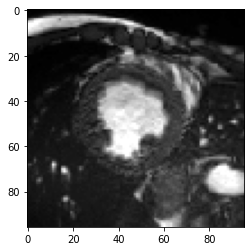

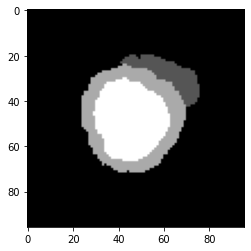

torch.Size([2, 96, 96])


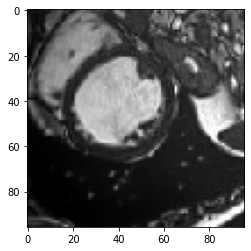

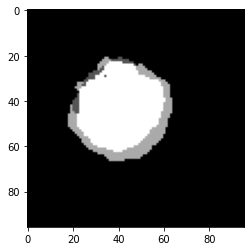

torch.Size([2, 96, 96])


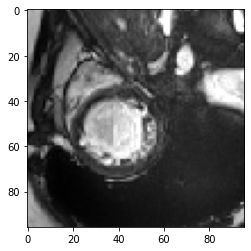

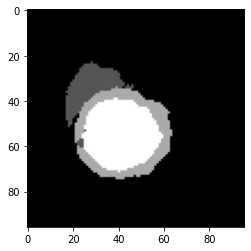

torch.Size([2, 96, 96])


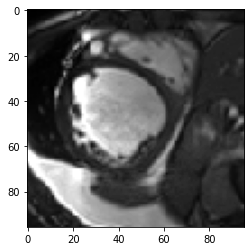

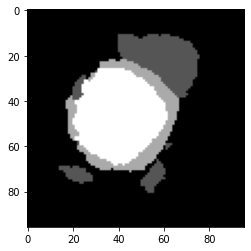

torch.Size([2, 96, 96])


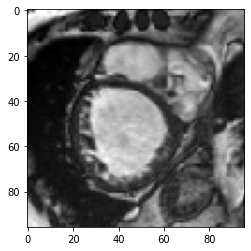

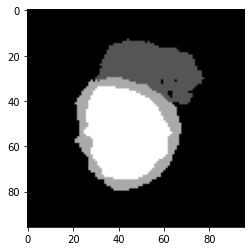

torch.Size([2, 96, 96])


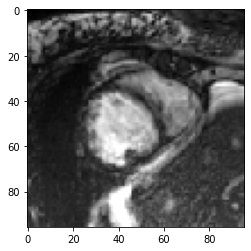

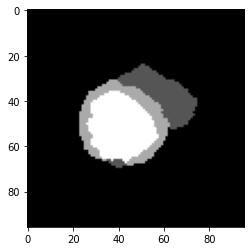

torch.Size([2, 96, 96])


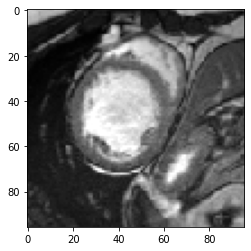

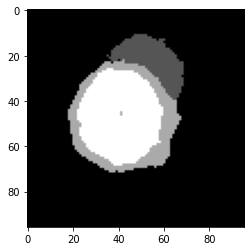

torch.Size([2, 96, 96])


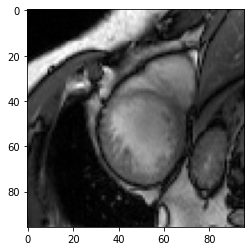

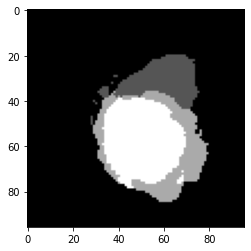

torch.Size([2, 96, 96])


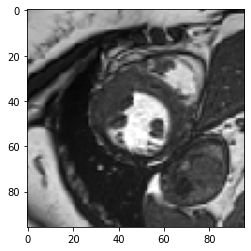

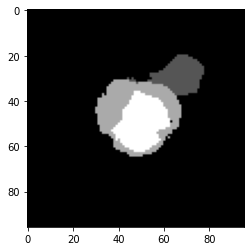

torch.Size([2, 96, 96])


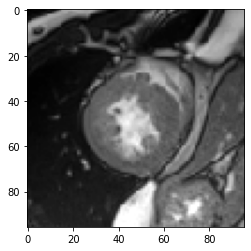

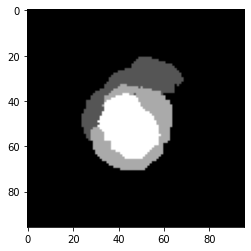

torch.Size([2, 96, 96])


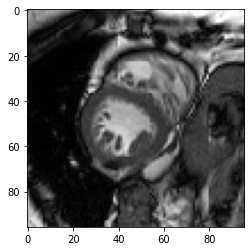

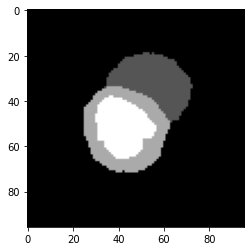

torch.Size([2, 96, 96])


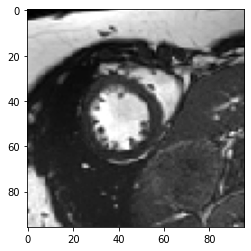

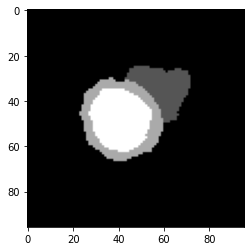

torch.Size([2, 96, 96])


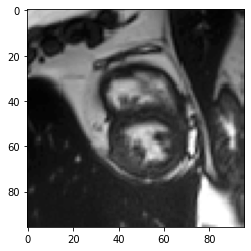

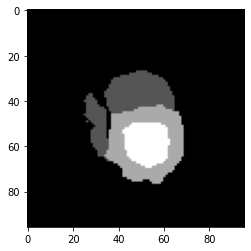

torch.Size([2, 96, 96])


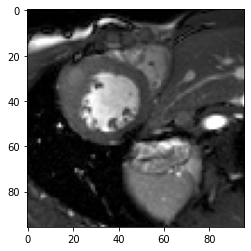

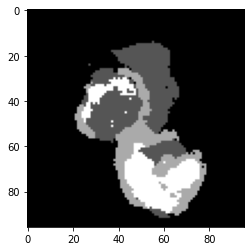

torch.Size([2, 96, 96])


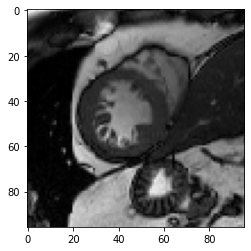

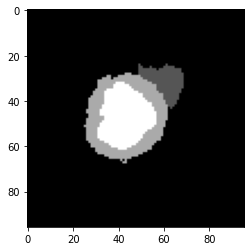

torch.Size([2, 96, 96])


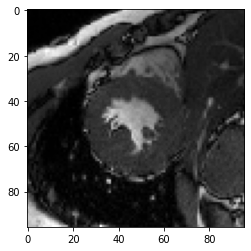

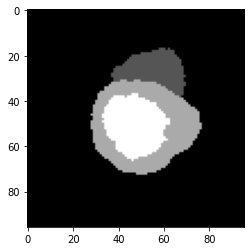

torch.Size([2, 96, 96])


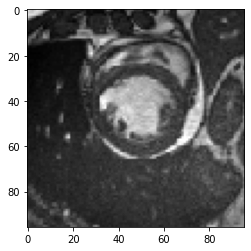

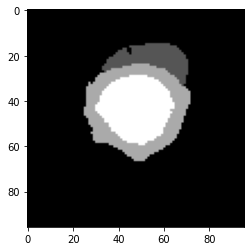

torch.Size([2, 96, 96])


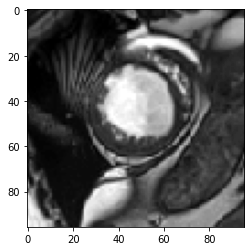

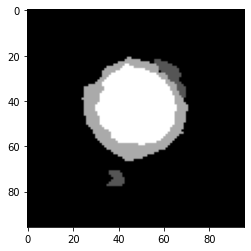

torch.Size([2, 96, 96])


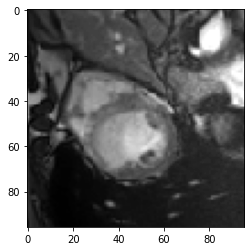

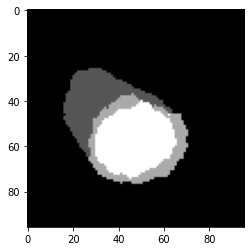

torch.Size([2, 96, 96])


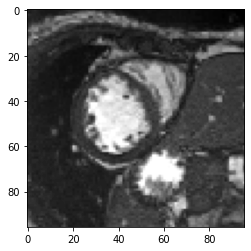

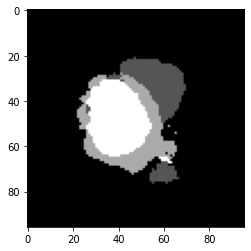

torch.Size([2, 96, 96])


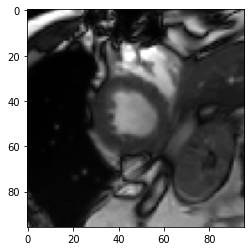

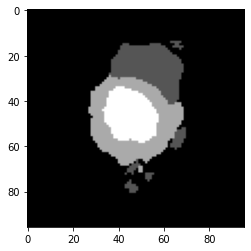

torch.Size([2, 96, 96])


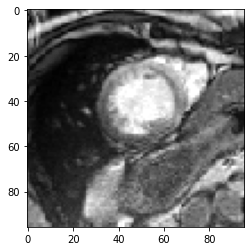

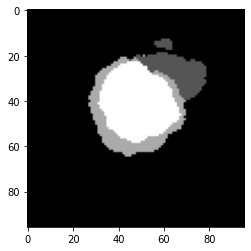

torch.Size([2, 96, 96])


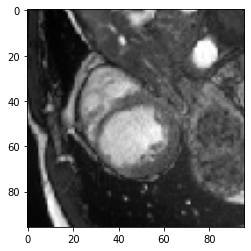

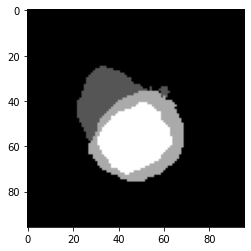

torch.Size([2, 96, 96])


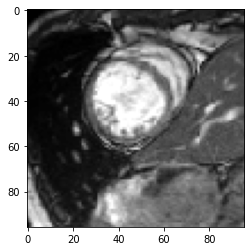

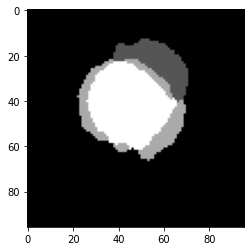

torch.Size([2, 96, 96])


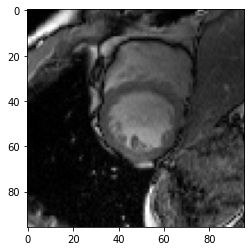

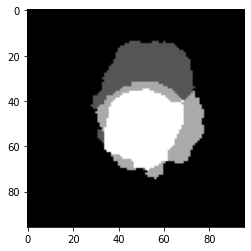

torch.Size([2, 96, 96])


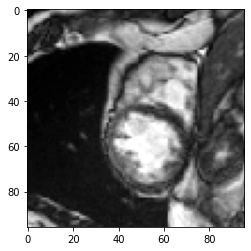

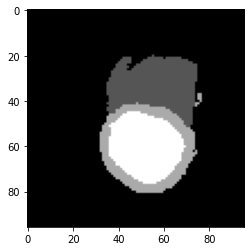

torch.Size([2, 96, 96])


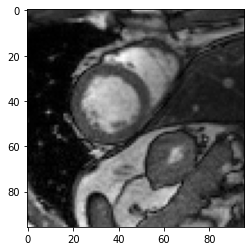

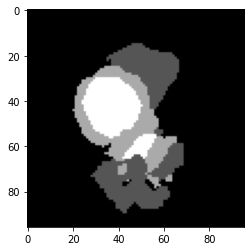

torch.Size([2, 96, 96])


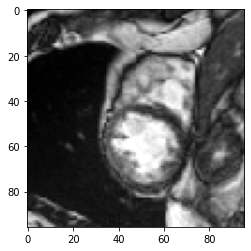

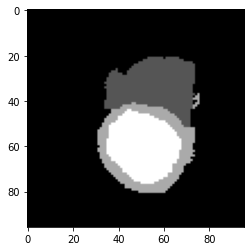

torch.Size([2, 96, 96])


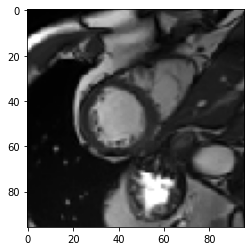

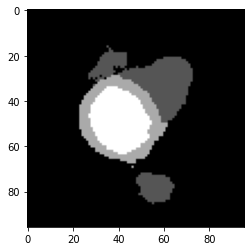

torch.Size([2, 96, 96])


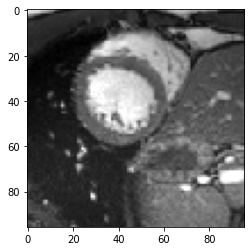

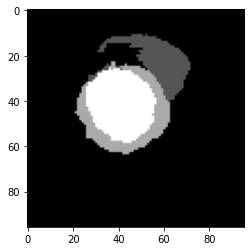

torch.Size([2, 96, 96])


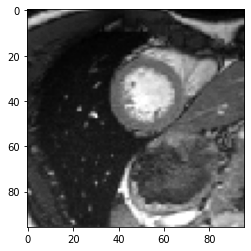

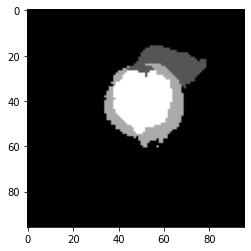

torch.Size([2, 96, 96])


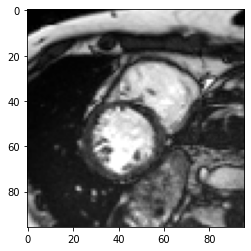

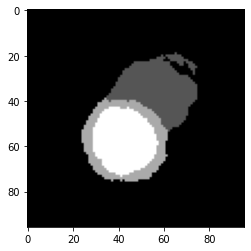

torch.Size([2, 96, 96])


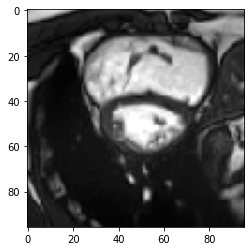

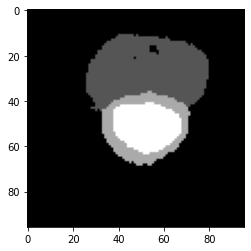

torch.Size([2, 96, 96])


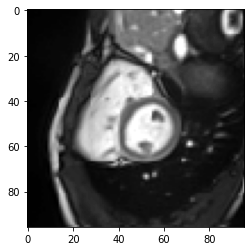

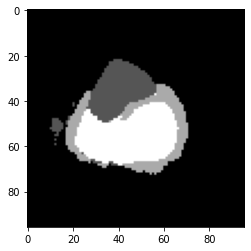

torch.Size([2, 96, 96])


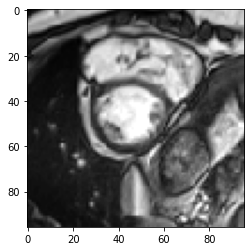

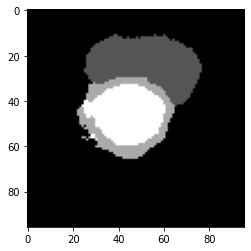

torch.Size([2, 96, 96])


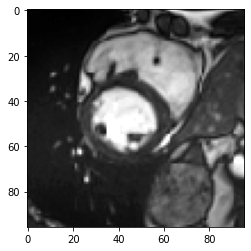

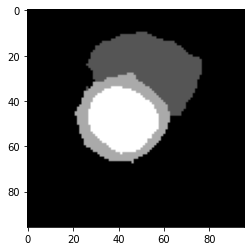

torch.Size([2, 96, 96])


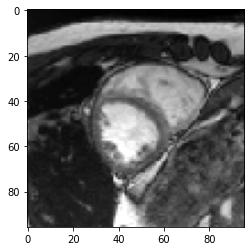

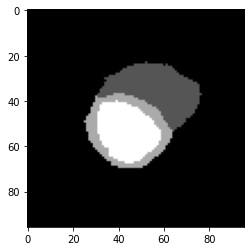

torch.Size([2, 96, 96])


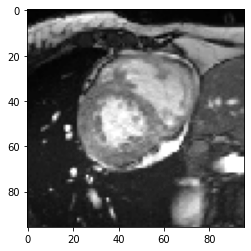

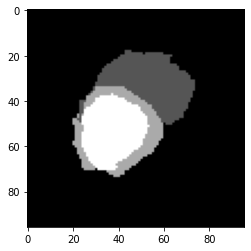

torch.Size([2, 96, 96])


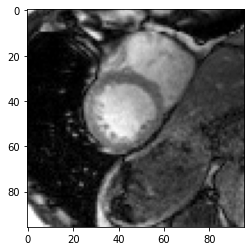

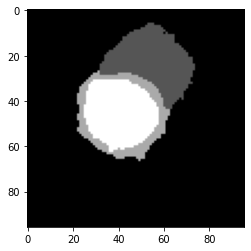

torch.Size([2, 96, 96])


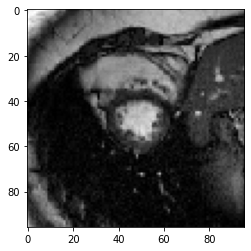

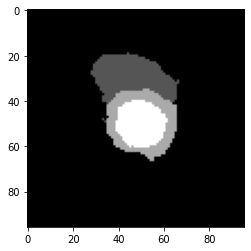

In [45]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 2

PATH = 'segNet.pkl'

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

testmodel = CNNSEG()
testmodel.load_state_dict(torch.load(PATH))
testmodel.eval()
index = 0
for iteration, sample in enumerate(test_data_loader):
    img = sample
    print(img.shape)
    out = testmodel(img.unsqueeze(1))
    _,out = torch.max(out,dim=1)
    
    for i in range(batch_size):
        cv2.imwrite(os.path.join('./data/test/mask/','cmr'+str(121+index)+'_mask.png'), out[i].detach().numpy())
        index+=1
    
    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    plt.pause(1)
    plt.imshow(out[0,...].squeeze(),cmap='gray')
    plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [7]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [47]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [48]:
mask_dir = './data/test/mask/'
save_path = './'

submission_converter(mask_dir,save_path)